<a href="https://colab.research.google.com/github/TheCodingCvrlo/bachelor-thesis/blob/main/spot_duplicates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Carlo Antonio Patti, 3134395
### Bocconi University, May 2023
A notebook written in fulfillment of the requirements for the Degree of Bachelor of Science in Economics, Management and Computer Science

# Tracing and Removing Duplicate Elements

In [ ]:
#@title Drive Mount
from google.colab import drive
drive.mount("drive", force_remount = True)

Mounted at drive


In [ ]:
#@title Imports
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
import pickle
from copy import Error
from copy import deepcopy as cp


#viz
import matplotlib.pyplot as plt
import seaborn as sns

#pytorch default imports
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

#llm
import spacy

In [ ]:
#@title Spacy Language Model Download
!python -m spacy download en_core_web_lg --quiet

2023-07-10 08:00:35.044412: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
PATH_REPS = "drive//MyDrive//thesis//data//representations.csv"

In [ ]:
df = pd.read_csv(PATH_REPS, index_col=0)

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,4793,4794,4795,4796,4797,4798,4799,artist,title,label
0,0.186423,0.054104,0.008338,0.298508,0.091317,0.562892,0.388584,0.447985,0.114253,0.373992,...,0.353654,0.380661,1.325894,0.153884,0.247429,-0.296933,0.205336,10cc,Les Nouveaux Riches,0
1,0.534583,0.519039,0.695587,0.154432,0.064010,1.019466,0.030198,0.300727,0.397662,0.841016,...,0.576871,1.072348,0.070084,0.784932,0.616306,-0.529404,0.266855,10cc,Listen With Your Eyes,0
2,-0.747218,-0.241643,0.208596,1.021109,0.895446,0.872237,-0.425431,0.614996,0.647687,1.499447,...,-0.321012,0.654247,1.167712,0.773478,0.788219,0.957022,0.501419,10cc,Lying Here With You,0
3,1.179623,0.771975,1.277992,1.298771,0.160453,0.788011,0.705584,0.370067,0.660782,0.227609,...,0.511090,0.139103,0.090255,0.274278,-0.598995,0.593601,0.395094,10cc,Margo Wants The Mustard,0
4,0.867722,0.077910,1.006646,0.811348,0.138325,1.092275,0.551503,0.547705,0.588275,0.629261,...,-0.211236,0.952863,0.904875,0.933412,0.469439,0.275433,-0.241763,10cc,Memories - U.S. Mix,0


In [ ]:
nlp = spacy.load('en_core_web_lg') #load language model

In [ ]:
#@title Duplicates Finder
#@markdown This utility leverages the `spacy` library's capabilities to define a similarity metric between subsequent song titles, after some text preprocessing steps. Observations whose similarity is over a predefined threshold are flagged as duplicates.
def find_duplicates(col, thresh=0.75, add_metadata=False, verbose=False):


  titles = list(col.values)

  #text preprocessing
  titles = [i.lower().strip() for i in titles]
  # titles = [i.split('album')[0] for i in titles] #drop "album version" and subsequent characters
  # titles = [i.split('(')[0].strip() for i in titles] #drop featurings and so
  titles = [i.replace(' _ ', ' & ') for i in titles]
  titles = [i.replace('_', '\'') for i in titles]

  #health check
  nulls  = sum([i == '' for i in titles])
  if verbose and nulls>0:
    print(f'WARNING: found {nulls} empty titles')

  #compute similarity between each element and the subsequent
  docs = [nlp(i) for i in titles]
  similarities = [docs[i].similarity(docs[i+1]) for i in range(len(docs)-1)]

  #retrieve indexes
  idx = np.where(np.array(similarities)>thresh)[0]

  if add_metadata:
    return idx, similarities, docs

  return idx

In [ ]:
#@title Visualization helper (find_duplicates preprocessing steps)
def prep_only(col, thresh=0.75, add_metadata=False, verbose=False):

  titles = list(col.values)

  #text preprocessing
  titles = [i.lower() for i in titles]
  titles = [i.split('album')[0] for i in titles] #drop "album version" and subsequent characters
  titles = [i.split('(')[0].strip() for i in titles] #drop featurings and so
  titles = [i.replace(' _ ', ' & ') for i in titles]
  titles = [i.replace('_', '\'') for i in titles]

  return pd.DataFrame(titles, columns = ['Processed title'])


# Full Implementation

In [ ]:
#call utility
duplicates_full = find_duplicates(df['title'], thresh=0.9)

<ipython-input-8-b373e8fde6ed>:22: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  similarities = [docs[i].similarity(docs[i+1]) for i in range(len(docs)-1)]


In [ ]:
df['dupe_flag'] = [1 if i in duplicates_full else 0 for i in range(df.shape[0])]

In [ ]:
df[df.artist=='2Pac'][['title', 'dupea_flag']] #table 3.1

,title,dupe_flag
358,Wit The Wrong Nigga - Album Version (Edited),0
359,2 Gangsta,0
360,"Ain't Hard 2 Find (ft. B-Legit, C-BO, E-40, Ri...",1
361,"Ain_t Hard 2 Find (ft. B-Legit, C-BO, E-40, Ri...",0
362,All Eyez On Me (ft. Big Syke),0
...,...,...
564,Happy Home II,0
565,Why U Turn On Me,0
566,Too Late - Isko Extended Mix,0
567,Too Late - Isko Radio Edit,0


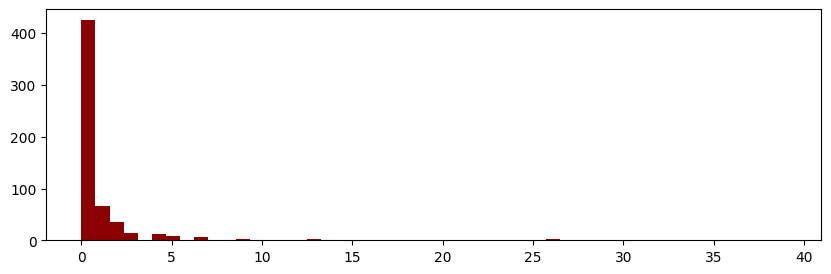

In [ ]:
#@title Visualisation: number-of-duplicates distribution (per artist)
n_duplicates = df.groupby('label')['dupe_flag'].sum()

fig,ax = plt.subplots(figsize=(10,3))
plt.hist(n_duplicates, bins=50, color='darkred')
plt.show()

In [ ]:
#export flags
PATH_OUT = "drive//MyDrive//thesis//data//flags//duplicate_flags.csv"

df['dupe_flag'].to_csv(PATH_OUT, index=False)

Carlo Antonio Patti, July 2023.


# Extra:  Figure 3.1

In [ ]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


scaler = StandardScaler()
projector = TSNE()

pipe_tsne = Pipeline([
    ('scaler', scaler),
    ('proj', projector)
])

In [ ]:

feats_pattern = r'^\d+$'
df_pac = df[df.artist=="2Pac"]
feats = df_pac.filter(regex=feats_pattern)

In [ ]:
df_pac[['artist', 'title']]

,artist,title
358,2Pac,Wit The Wrong Nigga - Album Version (Edited)
359,2Pac,2 Gangsta
360,2Pac,"Ain't Hard 2 Find (ft. B-Legit, C-BO, E-40, Ri..."
361,2Pac,"Ain_t Hard 2 Find (ft. B-Legit, C-BO, E-40, Ri..."
362,2Pac,All Eyez On Me (ft. Big Syke)
...,...,...
564,2Pac,Happy Home II
565,2Pac,Why U Turn On Me
566,2Pac,Too Late - Isko Extended Mix
567,2Pac,Too Late - Isko Radio Edit


In [ ]:
df_tsne = pd.DataFrame(pipe_tsne.fit_transform(feats), columns = ['x', 'y'], index=df_pac.index)

In [ ]:
df_tsne = pd.merge(df_tsne, df_pac[['artist', 'title', 'dupe_flag']], left_index=True, right_index=True)
data_showcase = df_tsne[df_tsne.title.str.startswith('Until The End')]
data_showcase2 = df_tsne[df_tsne.title.str.startswith('Holler If')]

In [ ]:
#@title Plot
import plotly.express as px
from plotly import graph_objects as go

fig = px.scatter(df_tsne,
                 x='x',
                 y='y',
                 hover_data=['title'],
                 labels={
                     "x": "",
                     "y": "",
                 })
fig.add_trace(
            go.Scatter(
                x=data_showcase.x,
                y=data_showcase.y,
                mode="markers+text",
                textfont=dict(
                      color="red",
                      size=18
                ),
                marker=dict(
                    color="red",
                    size=10
                ),
                text=["","Until The End Of Time","",""]
            )
)

fig.add_trace(
            go.Scatter(
                x=data_showcase2.x,
                y=data_showcase2.y,
                mode="markers+text",
                textfont=dict(
                      color="green",
                      size=18
                ),
                marker=dict(
                    color="green",
                    size=10
                ),
                text=["","Holler If Ya' Hear Me","",""]
            )
)

fig.update_layout(
    plot_bgcolor='white',
    showlegend=False,
    title_font_family="Times New Roman",
    font = dict(
        size = 20
    )
)
fig.update_xaxes(
    mirror=True,
    showline=False,
    linecolor='black',
    gridcolor='lightgrey',
    showticklabels=False
)
fig.update_yaxes(
    mirror=True,
    showline=False,
    linecolor='black',
    gridcolor='lightgrey',
    showticklabels=False
)
fig.update_traces(textposition='bottom left')
fig.for_each_trace(lambda t: t.update(textfont_color=t.marker.color))
fig.show()

# Extra: Dataset Cleaning

In [ ]:
artist = "Lil Wayne"
PATH_REPS_FOLDER = "drive//MyDrive//thesis//data//reps_longtitles"
PATH_ARTIST = PATH_REPS_FOLDER + f"//{artist}"

In [ ]:
# for each artist,
 # fetch first words of title,
 #if artist and title don't match:
  #flag

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,4794,4795,4796,4797,4798,4799,artist,title,label,dupe_flag
0,0.186423,0.054104,0.008338,0.298508,0.091317,0.562892,0.388584,0.447985,0.114253,0.373992,...,0.380661,1.325894,0.153884,0.247429,-0.296933,0.205336,10cc,Les Nouveaux Riches,0,0
1,0.534583,0.519039,0.695587,0.154432,0.064010,1.019466,0.030198,0.300727,0.397662,0.841016,...,1.072348,0.070084,0.784932,0.616306,-0.529404,0.266855,10cc,Listen With Your Eyes,0,0
2,-0.747218,-0.241643,0.208596,1.021109,0.895446,0.872237,-0.425431,0.614996,0.647687,1.499447,...,0.654247,1.167712,0.773478,0.788219,0.957022,0.501419,10cc,Lying Here With You,0,0
3,1.179623,0.771975,1.277992,1.298771,0.160453,0.788011,0.705584,0.370067,0.660782,0.227609,...,0.139103,0.090255,0.274278,-0.598995,0.593601,0.395094,10cc,Margo Wants The Mustard,0,0
4,0.867722,0.077910,1.006646,0.811348,0.138325,1.092275,0.551503,0.547705,0.588275,0.629261,...,0.952863,0.904875,0.933412,0.469439,0.275433,-0.241763,10cc,Memories - U.S. Mix,0,0


In [ ]:
def flag_feats(df):
  n = df.shape[0]

  out = np.zeros(n, dtype=int)

  for i in range(n):

    artist = df.artist.iloc[i]
    song = df.title.iloc[i]

    if song.startswith(artist):
      out[i] == 1

  return out

Carlo Antonio Patti, August 2023